In [130]:
__COLAB_ACTIVE = False
__POOL_MODEL = True

# Проект 3. Решить задачу DaNetQA / BoolQ

Можно решить как задачу для русского, так и для английского.

Либо провести эксперименты с многоязычной моделью

https://russiansuperglue.com/ru/tasks/task_info/DaNetQA

## Описание
Причинно-следственная связь, логический вывод, Natural Language Inference

DaNetQA - это набор да/нет вопросов с ответами и фрагментом текста, содержащим ответ. Все вопросы были написаны авторами без каких-либо искусственных ограничений.

Каждый пример представляет собой триплет (вопрос, фрагмент текста, ответ) с заголовком страницы в качестве необязательного дополнительного контекста.

Настройка классификации текстовых пар аналогична существующим задачам логического вывода (NLI)

### Тип задачи
Логика, Commonsense, Знания о мире. Бинарная классификация: true/false

## Import

In [131]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import os

base_path = os.path.abspath('')
if __COLAB_ACTIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = os.path.join(base_path, 'drive/MyDrive/DSnML_Innopolis2022')

print(f"Root path: '{base_path}'")

trainPartNameRaw = 'raw_train'
testPartNameRaw = 'raw_val'
validatePartNameRaw = 'raw_test'

trainPartName = 'train_v1'
testPartName = 'val_v1'
validatePartName = 'test_v1'
parts = [trainPartName, testPartName]
data_path = os.path.join(base_path, 'DaNetQA')
print(f"Dataset path: {data_path}")

Root path: 'd:\New folder\New folder\DSnML_Innopolis2022\00_Final_Attestation'
Dataset path: d:\New folder\New folder\DSnML_Innopolis2022\00_Final_Attestation\DaNetQA


In [132]:
def fileNameData(s):
    return f"{os.path.join(data_path, s)}.jsonl"

## Подготовка данных

### Imports

In [133]:
import pandas as pd
import unicodedata
import numpy as np

import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 

In [134]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leysh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Загрузка данных

In [135]:
def loadJSONL(path, name):
    df = pd.read_json(path, lines=True)
    print(name)
    display(df.head())
    if (df.columns.values == 'label').any():
        s = np.unique(df['label'].to_numpy(), return_counts=True)[1]
        print(f"True answer: {s[1]}")
        print(f"False answer: {s[0]}")
        print("")
    return df

In [136]:
df_train = loadJSONL(fileNameData(trainPartNameRaw), "Train set")
df_test = loadJSONL(fileNameData(testPartNameRaw), "Test set:")
df_validation = loadJSONL(fileNameData(validatePartNameRaw), "Validation set")

Train set


,question,passage,label,idx
0,Вднх - это выставочный центр?,«Вы́ставочный центр» — станция Московского мон...,True,0
1,Вднх - это выставочный центр?,"Вы́ставка достиже́ний наро́дного хозя́йства ,...",True,1
2,Был ли джиган в black star?,Вместе с этим треком они выступили на церемони...,True,2
3,Xiaomi конкурент apple?,"Xiaomi — китайская компания, основанная в 2010...",True,3
4,Был ли автомат калашникова в вов?,Отметив некоторые недостатки и в целом удачную...,False,4


True answer: 1061
False answer: 688

Test set:


,question,passage,label,idx
0,вода марсе ?,гидросфера марса — это совокупность водных зап...,True,0
1,состоит англия евросоюзе ?,полночь 31 января 1 февраля 2020 года централь...,False,1
2,деиствительно ссср адвокатов ?,семен львович ария — советскии россиискии юрис...,False,2
3,чума оране ?,"чума — это абсурд , осмысливается форма сущест...",True,3
4,кетчуп читосе ?,текущии каталог продукции размещен саите произ...,True,4


True answer: 412
False answer: 409

Validation set


,question,passage,idx
0,Полезна ли ртуть с градусника?,"Отравления ртутью — расстройства здоровья, св...",0
1,Являются ли сапрофаги хищниками?,Фауна лесных почв — совокупность видов животны...,1
2,Водятся ли в индии крокодилы?,"Болотный крокодил, или магер — пресмыкающееся...",2
3,Есть ли в батате крахмал?,"Клубневидно вздутые корни весят до 15 кг, сод...",3
4,Был ли человек в железной маске?,Остров Сент-Маргерит — крупнейший из Лерински...,4


### Очистка данных

In [137]:
class DataCleaner:
    def __init__(self) -> None:
        self.flag_verbose = True

        self.stop_words = stopwords.words('russian')
        self.stemmer = SnowballStemmer('russian')

        self.count_removed_symbols = dict()
        self.count_removed_words = dict()

        self.count_replaced_symbols = dict()
        self.dict_replaced_symbols = dict()

        self.count_replaced_words = dict()
        self.dict_replaced_words = dict()

        self.char_to_remove = ['«', '»', '—', ',', '.', '-', '/', ':', '!', "?", "(", ")", "{", "}", "[", "]", "@", "#", "$", "%", "^", "&", "*", "=", "|", "\\", ">", "<"]
        self.char_to_replace = [['ё', 'е']]

    # функция подсчета количества измененных слов
    def addReplacedWord(self, s_from, s_to = ' '):
        if not self.count_replaced_words.keys().__contains__(s_from):
            self.count_replaced_words[s_from] = 0
        self.count_replaced_words[s_from] += 1
        self.dict_replaced_words[s_from] = s_to

    # функция подсчета количества удаленных слов
    def addRemovedWord(self, w):
        if w == ' ':
            if not self.count_removed_symbols.keys().__contains__(w):
                self.count_removed_symbols[w] = 0
            self.count_removed_symbols[w] += 1

    # функция подсчета количества удаленных символов
    def addReplacedSymbol(self, s_from, s_to = ' '):
        if s_to == ' ':
            if not self.count_removed_symbols.keys().__contains__(s_from):
                self.count_removed_symbols[s_from] = 0
            self.count_removed_symbols[s_from] += 1
        else:
            if not self.count_replaced_symbols.keys().__contains__(s_from):
                self.count_replaced_symbols[s_from] = 0
            self.count_replaced_symbols[s_from] += 1
            self.dict_replaced_symbols[s_from] = s_to

    # удаление знаков ударения и прочих символов unicode
    def unicodeToAscii(self, s):
        tmp = []
        for c in unicodedata.normalize('NFD', s):
            if unicodedata.category(c) != 'Mn':
                tmp.append(c)
            else:
                self.addReplacedSymbol(c)
        return ''.join(tmp)

    # если нужно удалить, то заменяем на пробел чтоб не потерят разделения слов
    def replaceChar(self, s):
        tmp = []
        for i, c in enumerate(s):
            if self.char_to_remove.__contains__(c):
                self.addReplacedSymbol(c, s[i])
                tmp.append(' ')
            else:
                tmp.append(c)
        s = "".join(tmp)

        for s_from, s_to in self.char_to_replace:
            if c == s_from:
                s[i] = s_to
                self.addReplacedSymbol(s_from, s_to)
        return s

    # удаляем лишние пробелы
    def trimSpaces(self, s):
        while s.__contains__('  '):
            s = s.replace('  ', ' ')
        s = s.strip()
        return s

    # удаляем слва из stopwords
    def removeStopWords(self, s):
        tmp = []
        for word in word_tokenize(s):
            if word not in self.stop_words:
                tmp.append(word)
            else:
                self.addRemovedWord(word)
        return " ".join(tmp)

    # удаляем слва из stopwords
    def StemmWords(self, s):
        tmp = []
        for word in word_tokenize(s):
            wordStemmed = self.stemmer.stem(word)
            tmp.append(wordStemmed)
            if word != wordStemmed:
                self.addReplacedWord(word, wordStemmed)
        return " ".join(tmp)

    def clean(self, df, column):
        for i in range(len(df)):
            df[column][i] = self.unicodeToAscii(df[column][i])
            df[column][i] = df[column][i].lower()
            df[column][i] = self.replaceChar(df[column][i])
            df[column][i] = self.removeStopWords(df[column][i])
            df[column][i] = self.StemmWords(df[column][i])
            df[column][i] = self.trimSpaces(df[column][i])
        return df

    # прокси для выключения вывода на экран summary
    def print(self, vals):
        if self.flag_verbose == True:
            print(vals)

    # прокси для выключения вывода на экран summary
    def display(self, vals):
            if self.flag_verbose == True:
                display(vals)

    # сбор лога в dataframe, опциональный вывод на экран 
    def summary(self, verbose = True):
        self.flag_verbose = verbose
        dfs = []

        self.print("===================================")
        self.print("===        Removed Chars        ===")
        self.print("===================================")
        
        cols = ["symbol", "count_removed"]
        dfRemoved = pd.DataFrame(columns=cols)
        for c in self.count_removed_symbols:
            current_df = pd.DataFrame([[c, self.count_removed_symbols[c]]], columns=cols) 
            dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
        self.display(dfRemoved)
        dfs.append(['Removed Chars', dfRemoved])

        self.print("===================================")
        self.print("===        Removed Words        ===")
        self.print("===================================")
        
        cols = ["word", "count_removed"]
        dfRemoved = pd.DataFrame(columns=cols)
        for c in self.count_removed_words:
            current_df = pd.DataFrame([[c, self.count_removed_words[c]]], columns=cols) 
            dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
        self.display(dfRemoved)
        dfs.append(['Removed Words', dfRemoved])

        self.print("===================================")
        self.print("===        Replaced Chars       ===")
        self.print("===================================")
        
        cols = ["symbol_from", "symbol_to", "count_replaced"]
        dfRemoved = pd.DataFrame(columns=cols)
        for c in self.dict_replaced_symbols:
            current_df = pd.DataFrame([[ c, self.dict_replaced_symbols[c], self.count_replaced_symbols[c]]], columns=cols) 
            dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
        self.display(dfRemoved)
        dfs.append(['Replaced Chars', dfRemoved])

        self.print("===================================")
        self.print("===        Stemmed Words        ===")
        self.print("===================================")
        
        cols = ["word_from", "word_to", "count_replaced"]
        dfRemoved = pd.DataFrame(columns=cols)
        for c in self.dict_replaced_words:
            current_df = pd.DataFrame([[ c, self.dict_replaced_words[c], self.count_replaced_words[c]]], columns=cols) 
            dfRemoved = pd.concat([dfRemoved, current_df], ignore_index=True)
        self.display(dfRemoved)
        dfs.append(['Stemmed Words', dfRemoved])

        return dfs

In [138]:
t = DataCleaner()
df_train = t.clean(df_train, 'passage')
df_test = t.clean(df_test, 'passage')
df_validation = t.clean(df_validation, 'passage')
df_train = t.clean(df_train, 'question')
df_test = t.clean(df_test, 'question')
df_validation = t.clean(df_validation, 'question')

C:\Users\leysh\AppData\Local\Temp\ipykernel_2064\3611868607.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = self.unicodeToAscii(df[column][i])
C:\Users\leysh\AppData\Local\Temp\ipykernel_2064\3611868607.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = df[column][i].lower()
C:\Users\leysh\AppData\Local\Temp\ipykernel_2064\3611868607.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colum

In [139]:
dfs = t.summary()

===        Removed Chars        ===


,symbol,count_removed
0,́,1131
1,̆,20853
2,̈,4020
3,̔,5
4,̀,2
5,̣,6
6,̌,1
7,̥,1
8,̂,2
9,̊,2


===        Removed Words        ===


,word,count_removed


===        Replaced Chars       ===


,symbol_from,symbol_to,count_replaced
0,«,«,2246
1,»,»,2233
2,—,—,4524
3,.,.,19367
4,-,-,4010
5,",",",",27875
6,),),1430
7,:,:,1395
8,%,%,348
9,/,/,198


===        Stemmed Words        ===


,word_from,word_to,count_replaced
0,выставочныи,выставочны,7
1,станция,станц,7
2,московского,московск,26
3,монорельса,монорельс,2
4,расположена,располож,21
...,...,...,...
50960,себестоимость,себестоим,1
50961,ювелирная,ювелирн,1
50962,завоеван,завоева,1
50963,новорожденные,новорожден,1


In [140]:
df_train.passage[1]

'выставк достижен народн хозяиств 1959 1991 год выставк достижен народн хозяиств ссср 1992 2014 год всероссииск выставочны центр выставочны комплекс останкинск раион север восточн административн округ город москв второ величин выставочны комплекс город вход 50 крупнеиш выставочн центр мир ежегодн вднх посеща 30 млн гост 1 август 2019 год выставк отпразднова 80 летн юбил территориальн вднх объедин парк останкин главн ботаническ сад общ площад составля 700 га 240 2 га площад вднх 75 6 га площад парк останкин 361 га площад гбс 9 5 га музеин выставочны центр рабоч колхозниц площад арко главн вход территор выставк располож множеств шедевр архитектур 49 объект вднх призна памятник культурн наслед'

In [141]:
df_train.to_json(fileNameData(trainPartName), force_ascii=False, lines=True, orient='records')
df_test.to_json(fileNameData(testPartNameRaw), force_ascii=False, lines=True, orient='records')
df_validation.to_json(fileNameData(validatePartName), force_ascii=False, lines=True, orient='records')

## TF-IDF + LogisticRegression

In [143]:
import codecs
import json
from sklearn.linear_model import LogisticRegression
import pickle
import joblib

### Model Define

In [144]:
def build_feature_DaNetQA(row):
    res = str(row["question"]).strip()
    label = row.get("label")
    return res, label

In [145]:
def build_features_DaNetQA(path, vect):
    with codecs.open(path, encoding='utf-8-sig') as reader:
        lines = reader.read().split("\n")
        lines = list(map(json.loads, filter(None, lines)))
    res = list(map(build_feature_DaNetQA, lines))
    texts = list(map(lambda x: x[0], res))
    labels = list(map(lambda x: x[1], res))
    ids = [x["idx"] for x in lines]
    return (vect.transform(texts), labels), ids

In [146]:
def fit_DaNetQA(train, labels):
    clf = LogisticRegression()
    return clf.fit(train, labels)

In [147]:
def eval_DaNetQA(train_path, val_path, test_path, vect):
    train, _ = build_features_DaNetQA(train_path, vect)
    val, _ = build_features_DaNetQA(val_path, vect)
    test, ids = build_features_DaNetQA(test_path, vect)
    clf = fit_DaNetQA(*train)
    try:
        test_score = clf.score(*test)
    except ValueError:
        test_score = None
    test_pred = clf.predict(test[0])
    return clf, {
        "train": clf.score(*train),
        "val": clf.score(*val),
        "test": test_score,
        "test_pred": [{"idx": idx, "label": str(label).lower()} for idx, label in zip(ids, test_pred)]
    }

### Load Pre-Trained TF-IDF

In [148]:
!wget https://russiansuperglue.com/tasks/tf_idf
!unzip tf_idf_baseline.zip
!rm tf_idf_baseline.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [149]:
vect = joblib.load("tfidf.pkl")

c:\Users\leysh\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\leysh\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Score Model

#### On Raw Data

In [150]:
train_path = fileNameData(trainPartNameRaw)
test_path = fileNameData(testPartNameRaw)
val_path = fileNameData(validatePartNameRaw)

In [151]:
_, DaNetQA_scores = eval_DaNetQA(train_path, test_path, val_path, vect)
print(f'Accuracy on train data = {DaNetQA_scores["train"]}')
print(f'Accuracy on validation data = {DaNetQA_scores["val"]}')

Accuracy on train data = 0.8010291595197255
Accuracy on validation data = 0.5091352009744214


#### On Pre-Cleaned Data

In [152]:
train_path = fileNameData(trainPartName)
test_path = fileNameData(testPartName)
val_path = fileNameData(validatePartName)

In [153]:
_, DaNetQA_Cleared_scores = eval_DaNetQA(train_path, test_path, val_path, vect)
print(f'Accuracy on train data = {DaNetQA_Cleared_scores["train"]}')
print(f'Accuracy on validation data = {DaNetQA_Cleared_scores["val"]}')


Accuracy on train data = 0.7004002287021155
Accuracy on validation data = 0.5249695493300852


## Fine tune

### Impot

In [154]:
if 0:
    !pip install tensorflow
    !pip install pandas
    !pip install scipy
    !pip install transformers
    !pip install sklearn

In [155]:
import random
import pandas as pd
import numpy as np
import json

import torch
print(f"Cuda is available: {torch.cuda.is_available()}")

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_ as clip_grad_norm 

from transformers import BertTokenizer, BertConfig
from transformers.optimization import AdamW

from scipy.special import expit
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

Cuda is available: True


In [156]:
from utils import seed_everything
from utils import seed_worker

In [157]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Utils

#### Encode text

In [158]:
def collectAttentionMask(seq):
    return [float(i > 0) for i in seq]

In [159]:
def collectTokenType(row, sepTokenIdx):
    row = np.array(row)
    mask = row == sepTokenIdx

    whereMask = np.where(mask)[0]
    idx = whereMask[0]
    idx1 = whereMask[1]

    token_type_row = np.zeros(row.shape[0], dtype=np.int32)
    token_type_row[idx + 1:idx1 + 1] = 1
    return token_type_row

In [160]:
def encode_text_pairs(tokenizer, sentences):
    ENCODE_BATCH_SIZE = 20000
    input_ids, attention_masks, token_type_ids = [], [], []
    
    clsTokenText = '[CLS]'
    sepTokenText = '[SEP]'
    sepTokenIdx = tokenizer.convert_tokens_to_ids(sepTokenText)

    TEXT1_MAX = int(MAX_LEN*.75) # выделяет 75% размера слов для контекста
    TEXT2_MAX = MAX_LEN - TEXT1_MAX # остальные слова это вопрос
    for _, i in enumerate(range(0, len(sentences), ENCODE_BATCH_SIZE)):
        # обрезаем предложение слов больше чем MAX_LEN
        tokenized_texts = []
        for sentence_context, sentence_question  in sentences[i:i + ENCODE_BATCH_SIZE]:
            p1 = [clsTokenText] + tokenizer.tokenize(sentence_context)
            p2 = [sepTokenText] + tokenizer.tokenize(sentence_question) + [sepTokenText]
            final_tokens = p1[:TEXT1_MAX] + p2[:TEXT2_MAX]
            tokenized_texts.append(final_tokens)

        # токенизируем
        b_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
        b_input_ids = pad_sequences(
            b_input_ids, 
            maxlen=MAX_LEN, 
            dtype='long', 
            truncating='post', 
            padding='post')
        input_ids.append(b_input_ids)

        # маска внимания
        b_attention_masks = [collectAttentionMask(seq) for seq in b_input_ids]
        attention_masks.append(b_attention_masks)

        # тип токена
        b_token_type_ids = [collectTokenType(row, sepTokenIdx) for row in b_input_ids]
        token_type_ids.append(b_token_type_ids)
        
    return np.vstack(input_ids), np.vstack(attention_masks), np.vstack(token_type_ids)

#### Create DataLoader

In [161]:
def createDataLoader(set_ids, all_ids, input_ids, attention_masks, token_type_ids, all_labels, BATCH_SIZE_LOADER):
    mask = np.array([sid in set_ids for sid in all_ids])

    inputs = input_ids[mask]
    masks = attention_masks[mask]
    type_ids_dev = token_type_ids[mask]
    labels = all_labels[mask]

    t_inputs = torch.tensor(inputs)
    t_masks = torch.tensor(masks)
    t_type_ids_dev = torch.tensor(type_ids_dev)
    t_labels = torch.tensor(labels)

    t_dataset = TensorDataset(
        t_inputs, 
        t_masks, 
        t_type_ids_dev, 
        t_labels)
    t_sampler = SequentialSampler(t_dataset)

    return DataLoader(
        dataset=t_dataset, 
        sampler=t_sampler, 
        batch_size=BATCH_SIZE_LOADER, 
        worker_init_fn=seed_worker)

In [162]:
def getYFromDataLoader(dl):
    return np.argmax(dl.dataset.__dict__['tensors'][3], axis=1)

#### Evaluate Model

In [163]:
def evaluateModel(model, in_dataloader, device):
    model.eval()

    predictions = []
    accumulate_loss = 0
    accumulate_step = 0
    for _, batch in enumerate(in_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch

        with torch.no_grad():
            outputs = model(
                b_input_ids,
                token_type_ids = b_token_type_ids, 
                attention_mask = b_input_mask, 
                labels = b_labels)
            loss, logits = outputs[:2]
            
            accumulate_loss += loss.item()
            accumulate_step += 1

            logits = logits.detach().cpu().numpy()
            predictions.append(logits)

    avg_loss = accumulate_loss / accumulate_step

    predictions = expit(np.vstack(predictions))
    predictions = np.argmax(predictions, axis=1)

    y_true = getYFromDataLoader(in_dataloader)
    score = accuracy_score(y_true, predictions)

    return score, avg_loss, predictions

#### Train One Iteration

In [164]:
def trainModelIteration(model, optimizer, scheduler, in_dataloader, MAX_GRAD_NORM, EPOCH_INDEX):
    model.train() 
    torch.cuda.empty_cache()

    predictions = []
    accumulate_loss = 0
    accumulate_step = 0

    nStep = len(in_dataloader)
    for step, batch in enumerate(in_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch
        
        optimizer.zero_grad()

        outputs = model(
            b_input_ids,
            token_type_ids = b_token_type_ids, 
            attention_mask = b_input_mask, 
            labels = b_labels
            )
        loss, logits = outputs[:2]

        logits = logits.detach().cpu().numpy()
        predictions.append(logits)

        loss.backward()
        clip_grad_norm(model.parameters(), MAX_GRAD_NORM)

        optimizer.step()
        scheduler.step()

        epochLoss = loss.item()
        accumulate_loss += epochLoss
        accumulate_step += 1
        
        print(f"Epoch {EPOCH_INDEX} Step {step} of {nStep}, loss = {epochLoss}")

    avg_loss = accumulate_loss / accumulate_step

    predictions = expit(np.vstack(predictions))
    predictions = np.argmax(predictions, axis=1)

    y_true = getYFromDataLoader(in_dataloader)
    score = accuracy_score(y_true, predictions)

    return score, avg_loss, predictions

### Read Dataset

In [165]:
text1_id, text2_id, label_id, index_id = 'passage', 'question', 'label', 'idx'
l2i = {False: 0, True:1}
part2indices = {p:set() for p in parts}

all_ids, all_sentences, all_labels = [], [], []
idxMax = 0
for p in parts:
    df = pd.read_json(fileNameData(p), lines=True)
    ids = idxMax + df[index_id].to_numpy()
    all_ids.extend(ids)
    idxMax = np.max(all_ids)
    
    part2indices[p] = ids
    all_labels.extend(df[label_id].to_numpy())
    all_sentences.extend(
        np.array(
            np.column_stack([df[text1_id].to_numpy(), 
            df[text2_id].to_numpy()])
        ).tolist())

all_ids = np.array(all_ids)

In [166]:
print ('len(total)', len(all_sentences))
i2l = {l2i[l]:l for l in l2i}
print ( 'len(l2i)', len(l2i) )

len(total) 2570
len(l2i) 2


In [167]:
label_indices = np.array([l2i[l] for l in all_labels])
labels = np.zeros((len(all_ids), len(l2i)))
for _, i in enumerate(label_indices):
    labels[_, i] = 1

In [168]:
y_test =  label_indices[np.array([sid in part2indices['val_v1'] for sid in all_ids])]
y_train =  label_indices[np.array([sid in part2indices['train_v1'] for sid in all_ids])]

### Model RuBert-Cased

In [169]:
if __POOL_MODEL:
    from utils import PoolBertForSequenceClassification as BertModel
else:
    from transformers import BertForSequenceClassification as BertModel

In [170]:
SEED = 128
MAX_LEN = 256

BATCH_SIZE = 16
BATCH_SIZE_LOADER = 8
EPOCHS_LIMIT = 25
LEARNING_RATE = 3e-5
MAX_GRAD_NORM = 1.0

In [171]:
!wget "http://files.deeppavlov.ai/deeppavlov_data/bert/rubert_cased_L-12_H-768_A-12_pt.tar.gz"
!tar -xvzf rubert_cased_L-12_H-768_A-12_pt.tar.gz
!rm rubert_cased_L-12_H-768_A-12_pt.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'rubert_cased_L-12_H-768_A-12_pt.tar.gz'
'rm' is not recognized as an internal or external command,
operable program or batch file.


In [172]:
model_path = os.path.join(base_path, 'rubert_cased_L-12_H-768_A-12_pt/')
print(model_path)

d:\New folder\New folder\DSnML_Innopolis2022\00_Final_Attestation\rubert_cased_L-12_H-768_A-12_pt/


#### One-Hot Encode

In [173]:
tokenizer = BertTokenizer.from_pretrained(
    pretrained_model_name_or_path = os.path.join(base_path, model_path),
    do_lower_case=True,
    max_length=MAX_LEN)

In [174]:
input_ids, attention_masks, token_type_ids = encode_text_pairs(tokenizer, all_sentences)

#### Prepeare Data Loaders

In [175]:
test_dataloader = createDataLoader(part2indices['val_v1'], 
    all_ids, input_ids, attention_masks, token_type_ids, labels, BATCH_SIZE_LOADER)
train_dataloader = createDataLoader(part2indices['train_v1'], 
    all_ids, input_ids, attention_masks, token_type_ids, labels, BATCH_SIZE_LOADER)
validate_dataloader = createDataLoader(part2indices['val_v1'], 
    all_ids, input_ids, attention_masks, token_type_ids, labels, BATCH_SIZE_LOADER)

In [176]:
print (f'Training set shape: {train_dataloader.dataset.__dict__["tensors"][0].shape}')
print (f'Validation set shape: {test_dataloader.dataset.__dict__["tensors"][0].shape}')
print (f'Validation set shape: {validate_dataloader.dataset.__dict__["tensors"][0].shape}')

Training set shape: torch.Size([1750, 256])
Validation set shape: torch.Size([822, 256])
Validation set shape: torch.Size([822, 256])


#### Load Pre-Trained BERT model

In [1]:
seed_everything(SEED)
config_path = os.path.join(base_path, model_path, 'bert_config.json')
conf = BertConfig.from_json_file(config_path)
conf.num_labels = len(l2i)

output_model_file = os.path.join(base_path, model_path, 'pytorch_model.bin')

model = BertModel(conf)

model.load_state_dict(torch.load(output_model_file), strict=False)
model = model.cuda()

NameError: name 'seed_everything' is not defined


##### Limit learning for BERT layers

In [178]:
param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
]

#### Optimizer & Scheduler
Задаем гиперпараметры для цикла обучения

In [180]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(
    optimizer_grouped_parameters, 
    lr=LEARNING_RATE, 
    correct_bias=False)
    
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=LEARNING_RATE, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS_LIMIT)

c:\Users\leysh\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#### Train Loop

In [181]:
bert_train_predict = []
bert_test_predict = []

bert_avg_train_loss = []
bert_avg_test_loss = []

bert_train_acc = []
bert_test_acc = []

In [182]:
for iEpoch in range(15):

    # train
    train_score, avg_train_loss, y_train_prediction = trainModelIteration(
        model, optimizer, scheduler, train_dataloader, MAX_GRAD_NORM, iEpoch)
    
    bert_train_acc.append(train_score)
    bert_avg_train_loss.append(avg_train_loss)
    bert_train_predict.append(y_train_prediction)

    ### evaluate
    test_score, avg_test_loss, y_test_prediction = evaluateModel(
        model, test_dataloader, device)

    bert_test_acc.append(test_score)
    bert_avg_test_loss.append(avg_test_loss)
    bert_test_predict.append(y_test_prediction)

    # log epoch
    print(f'Epoch {iEpoch} average train_loss: {avg_train_loss:.6f} test_loss: {avg_test_loss:.6f} test_score {test_score:.2f}%')

Epoch 0 Step 0 of 219, loss = 1.1648840170819312
Epoch 0 Step 1 of 219, loss = 0.9742748062126338
Epoch 0 Step 2 of 219, loss = 1.069280429277569
Epoch 0 Step 3 of 219, loss = 1.0660201665014029
Epoch 0 Step 4 of 219, loss = 1.0121560343541205
Epoch 0 Step 5 of 219, loss = 0.878244386985898
Epoch 0 Step 6 of 219, loss = 0.8139510974287987
Epoch 0 Step 7 of 219, loss = 0.7129489202052355
Epoch 0 Step 8 of 219, loss = 0.7512796418741345
Epoch 0 Step 9 of 219, loss = 0.587627271655947
Epoch 0 Step 10 of 219, loss = 0.5304310782812536
Epoch 0 Step 11 of 219, loss = 0.4581133765168488
Epoch 0 Step 12 of 219, loss = 0.48028083937242627
Epoch 0 Step 13 of 219, loss = 0.9146116706542671
Epoch 0 Step 14 of 219, loss = 0.4167641280218959
Epoch 0 Step 15 of 219, loss = 0.4478187318891287
Epoch 0 Step 16 of 219, loss = 0.4130536369048059
Epoch 0 Step 17 of 219, loss = 1.9040669035166502
Epoch 0 Step 18 of 219, loss = 0.8152113617397845
Epoch 0 Step 19 of 219, loss = 1.2541905138641596
Epoch 0 Step

#### Graphics

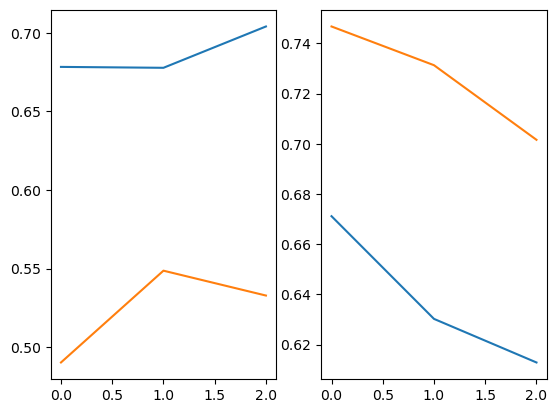

In [183]:
plt.subplot(1, 2, 1)
plt.plot(bert_train_acc)
plt.plot(bert_test_acc)

plt.subplot(1, 2, 2)
plt.plot(bert_avg_train_loss)
plt.plot(bert_avg_test_loss)

## Model RuBert-Large

In [184]:
#!git clone https://huggingface.co/sberbank-ai/ruRoberta-large

fatal: destination path 'ruRoberta-large' already exists and is not an empty directory.


In [ ]:
#model_path = os.path.join(base_path, 'ruRoberta-large/')
#print(model_path)
#
#config_path = os.path.join(base_path, model_path, 'config.json')
#conf = BertConfig.from_json_file(config_path)
#conf.num_labels = len(l2i)
#
#output_model_file = os.path.join(base_path, model_path, 'pytorch_model.bin')
#
#model = BertModel(conf)
#
#model.load_state_dict(torch.load(output_model_file), strict=False)
#model = model.cuda()

In [ ]:
seed_everything(SEED)

In [185]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruRoberta-large")

model = AutoModelForMaskedLM.from_pretrained("sberbank-ai/ruRoberta-large")
model = model.cuda()

In [187]:
param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay_rate': 0.0}
]

In [190]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(
    optimizer_grouped_parameters, 
    lr=LEARNING_RATE, 
    correct_bias=False)
    
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=LEARNING_RATE, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS_LIMIT)

c:\Users\leysh\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
lberta_train_predict = []
lberta_test_predict = []

lberta_avg_train_loss = []
lberta_avg_test_loss = []

lberta_train_acc = []
lberta_test_acc = []

In [191]:
for iEpoch in range(3):

    # train
    train_score, avg_train_loss, y_train_prediction = trainModelIteration(
        model, optimizer, scheduler, train_dataloader, MAX_GRAD_NORM, iEpoch)
    
    lberta_train_acc.append(train_score)
    lberta_avg_train_loss.append(avg_train_loss)
    lberta_train_predict.append(y_train_prediction)

    ### evaluate
    test_score, avg_test_loss, y_test_prediction = evaluateModel(
        model, test_dataloader, device)

    lberta_test_acc.append(test_score)
    lberta_avg_test_loss.append(avg_test_loss)
    lberta_test_predict.append(y_test_prediction)

    # log epoch
    print(f'Epoch {iEpoch} average train_loss: {avg_train_loss:.6f} test_loss: {avg_test_loss:.6f} test_score {test_score:.2f}%')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.